In [1]:
import wandb
import sys
sys.path.append('../src/')
from model import AEDist
from omegaconf import OmegaConf
from geodesic import ODEFunc, GeodesicODE
import os
import glob
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import scprep
import matplotlib.pyplot as plt

In [2]:
wandb.login()
api = wandb.Api()
entity = "xingzhis"
project = "dmae"
# run_id = 'iio2bb24'
run_id = 'h8cgye4i'
run = api.run(f"{entity}/{project}/{run_id}")
folder_path = '../src/wandb/'
cfg = OmegaConf.create(run.config)
folder_list = glob.glob(f"{folder_path}*{run.id}*")
ckpt_files = glob.glob(f"{folder_list[0]}/files/*.ckpt")
ckpt_path = ckpt_files[0]
data_path2 = os.path.join(cfg.data.root, cfg.data.name + cfg.data.filetype)
data = np.load(data_path2, allow_pickle=True)
model = AEDist.load_from_checkpoint(ckpt_path)
x_tensor = torch.tensor(data['data'], dtype=torch.float32, device=model.device)
# x_tensor_normalized = model.normalize(x_tensor)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: xingzhis. Use `wandb login --relogin` to force relogin
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_fn'])`.
  rank_zero_warn(


In [3]:
with torch.no_grad():
    z = model.encode(x_tensor)

In [4]:
# Swiss roll random integer
import torch
npts = len(z)
# np.random.seed(3245)
np.random.seed(2309)
pts = np.random.choice(npts, size=20, replace=False)
# start = np.random.randint(0,npts,size=1)
# starttwo = np.random.randint(0,npts,size=1)
# startthree = np.random.randint(0,npts,size=1)
# startfour = np.random.randint(0,npts,size=1)
# startfive= np.random.randint(0,npts,size=1)
# end = np.random.randint(0,npts,size=1)
#Select start and end points for NeuralODE

# x0 = torch.tensor(z[start,:]).cpu() #Start point
# x1 = torch.tensor(z[starttwo,:]).cpu() 
# x2 = torch.tensor(z[startthree,:]).cpu() 
# x3 = torch.tensor(z[startfour,:]).cpu() 
# x4 = torch.tensor(z[startfive,:]).cpu() 
# xfin = torch.tensor(z[end,:]).cpu() 
# xbatch = torch.cat((x0,x1,x2,x3,x4),0)
# endbtch = torch.cat((xfin,xfin,xfin,xfin,xfin),0)

xbatch = torch.tensor(z[pts[:10], :]).cpu()
endbtch = torch.tensor(z[pts[10:], :]).cpu()
# xfin = 

# print(xfin.shape)
print(xbatch.shape)
print(endbtch.shape)

torch.Size([10, 2])
torch.Size([10, 2])


/tmp/tmp.BajWSQNRFk/ipykernel_2102520/3687504044.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xbatch = torch.tensor(z[pts[:10], :]).cpu()
/tmp/tmp.BajWSQNRFk/ipykernel_2102520/3687504044.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  endbtch = torch.tensor(z[pts[10:], :]).cpu()


In [5]:
# fig, ax = plt.subplots()
# scprep.plot.scatter2d(z.detach().cpu().numpy(), ax=ax)
# for i in range(zhat_no_len_reg.shape[1]):
# # for i in [1]:
#     scprep.plot.scatter2d(xbatch[i].detach().cpu().numpy(), ax=ax, c='g')
#     scprep.plot.scatter2d(zhat_no_len_reg[:,i,:].detach().cpu().numpy(), ax=ax)
# scprep.plot.scatter2d(xfin[0].detach().cpu().numpy(), ax=ax, c='r')

In [6]:
xbatch.size()

torch.Size([10, 2])

In [7]:
endbtch.size()

torch.Size([10, 2])

In [8]:
dataset = TensorDataset(xbatch, endbtch)
dataloader = DataLoader(dataset, batch_size=len(xbatch), shuffle=True)

In [9]:
odemodel = GeodesicODE(in_dim=2, hidden_dim=64, fcn=model.decoder, lr=1e-2, beta=1)

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'fcn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['fcn'])`.
  rank_zero_warn(


In [10]:
odemodel.pretraining = True
pretrainer = pl.Trainer(max_epochs=200)
pretrainer.fit(odemodel, dataloader)

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_env ...
  rank_zero_warn(
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: Pos

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


In [11]:
with torch.no_grad():
    zhat_no_len_reg = odemodel(xbatch)

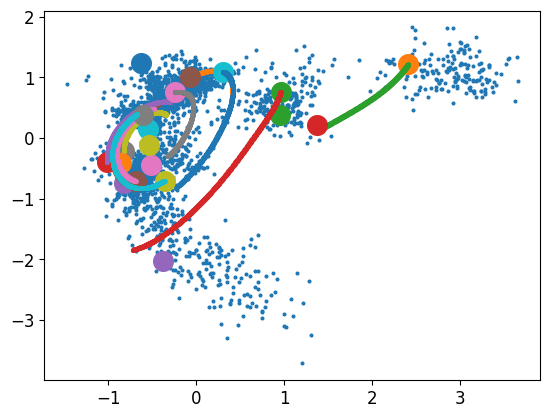

In [12]:
fig, ax = plt.subplots()
scprep.plot.scatter2d(z.detach().cpu().numpy(), ax=ax)
for i in range(zhat_no_len_reg.shape[1]):
# for i in [1]:
    scprep.plot.scatter2d(xbatch[i].detach().cpu().numpy(), ax=ax)
    scprep.plot.scatter2d(zhat_no_len_reg[:,i,:].detach().cpu().numpy(), ax=ax)
    scprep.plot.scatter2d(endbtch[i].detach().cpu().numpy(), ax=ax)
# scprep.plot.scatter2d(xfin[0].detach().cpu().numpy(), ax=ax)

In [13]:
odemodel.pretraining = False
odemodel.hparams.lr = 1e-3
odemodel.hparams.lam=5
odemodel.hparams.beta=5
pretrainer = pl.Trainer(max_epochs=200)
pretrainer.fit(odemodel, dataloader)

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_env ...
  rank_zero_warn(
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: Pos

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


In [14]:
with torch.no_grad():
    zhat = odemodel(xbatch)

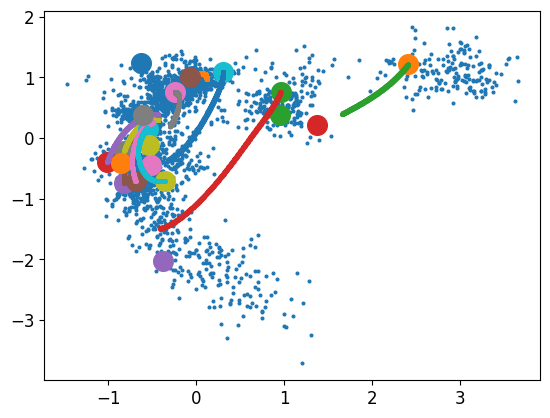

In [15]:
fig, ax = plt.subplots()
scprep.plot.scatter2d(z.detach().cpu().numpy(), ax=ax)
for i in range(zhat.shape[1]):
# for i in [1]:
    scprep.plot.scatter2d(xbatch[i].detach().cpu().numpy(), ax=ax)
    scprep.plot.scatter2d(zhat[:,i,:].detach().cpu().numpy(), ax=ax)
    scprep.plot.scatter2d(endbtch[i].detach().cpu().numpy(), ax=ax)
# scprep.plot.scatter2d(xfin[0].detach().cpu().numpy(), ax=ax)